In [1]:
from qiskit.quantum_info import Statevector
from numpy import sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import c2qa #Bosonic-qiskit
import qiskit
import c2qa
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi, ceil
from scipy.optimize import curve_fit
import numpy as np

In [3]:
X = QuantumRegister(1,"Qubit")
U = ClassicalRegister(1,"Classical")
circuit = QuantumCircuit(X,U)

circuit.h(X)
circuit.measure(X,U)

display(circuit.draw())

┌───┐┌─┐
      Qubit: ┤ H ├┤M├
             └───┘└╥┘
Classical: 1/══════╩═
                   0

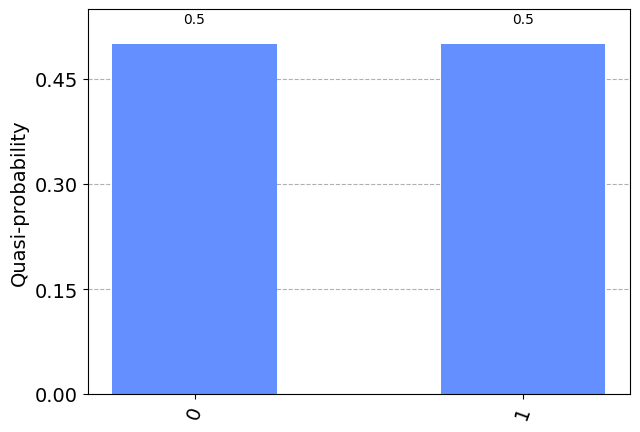

In [4]:
results = Sampler().run(circuit).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

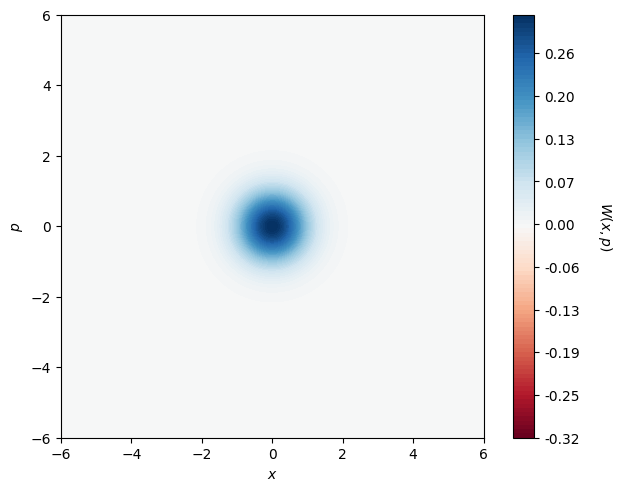

┌───────┐┌──────────┐
qumode_0: ┤0      ├┤0         ├
          │       ││          │
qumode_1: ┤1      ├┤1         ├
          │  S(0) ││          │
qumode_2: ┤2      ├┤2 Cr(π/4) ├
          │       ││          │
qumode_3: ┤3      ├┤3         ├
          └─┬───┬─┘│          │
   qubit: ──┤ H ├──┤4         ├
            └───┘  └──────────┘

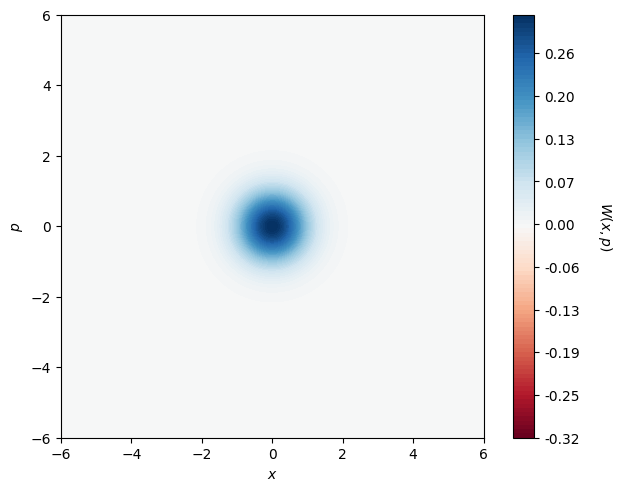

In [24]:
#setup registers for a squeeze state and a conditional rotation
qmr = c2qa.QumodeRegister(1,4,'qumode')
qbr = qiskit.QuantumRegister(1,'qubit')

#convenient labeling
qbit = qbr[0]
qumode = qmr[0]

#The circuit is initalized to |0>|0> by default
circuit = c2qa.CVCircuit(qmr, qbr)

#squeeze the qumode
circuit.cv_sq(0, qmr[0])

#plot the squeezed qumode
state, _, _ = c2qa.util.simulate(circuit)
c2qa.wigner.plot_wigner(circuit, state)

#put the qubit into a superposition and do a controlled rotation of the cavity
theta=pi/4
circuit.h(qbr[0])
circuit.cv_c_r(theta, qumode, qbit)


#simulate and plot
display(circuit.draw())
state, _, _ = c2qa.util.simulate(circuit)
c2qa.wigner.plot_wigner(circuit, state)

In [20]:
circuit.clear()

In [21]:
#initialize circuit
osc = c2qa.QumodeRegister(1,3,'qumode')
qbit = AncillaRegister(1, 'qubit')
cl = ClassicalRegister(1,'classical')
circ = c2qa.CVCircuit(osc,qbit,cl)

In [22]:
#initialize oscillator and ancillary qubit
circ.initialize([1, 0], qbit[0]) #initialize to |0>
circ.cv_initialize(2, osc) # |3> Fock state

In [23]:
#first Hadamard on the qbit
circ.h(qbit[0])
# Conditional phase space rotation gate
circ.cv_c_r(pi/2, osc[0], qbit[0])
# Non-conditional phase space rotation gate to correct global phase
circ.cv_r(-pi/2, osc[0])
# Hadamard on the qubit again, then measure
circ.h(qbit[0])
circ.cv_measure(qbit, cl)
_,_, counts = c2qa.util.simulate(circ)
print(counts)

{'0': 1024}


In [12]:
display(circ.draw())

┌──────────────────────────────┐     ┌──────────┐┌──────────┐   
   qumode_0: ┤0                             ├─────┤0         ├┤0         ├───
             │                              │     │          ││          │   
   qumode_1: ┤1 Initialize(0,0,1,0,0,0,0,0) ├─────┤1         ├┤1 R(-π/2) ├───
             │                              │     │  Cr(π/2) ││          │   
   qumode_2: ┤2                             ├─────┤2         ├┤2         ├───
             └─────┬─────────────────┬──────┘┌───┐│          │└──┬───┬───┘┌─┐
      qubit: ──────┤ Initialize(1,0) ├───────┤ H ├┤3         ├───┤ H ├────┤M├
                   └─────────────────┘       └───┘└──────────┘   └───┘    └╥┘
classical: 1/══════════════════════════════════════════════════════════════╩═
                                                                           0

In [ ]:
#initialize circuit for rotating a squeezed state
osc = c2qa.QumodeRegister(1,3,'qumode')
qbit = AncillaRegister(1, 'qubit')
cl = ClassicalRegister(1,'classical')
circ = c2qa.CVCircuit(osc,qbit,cl)

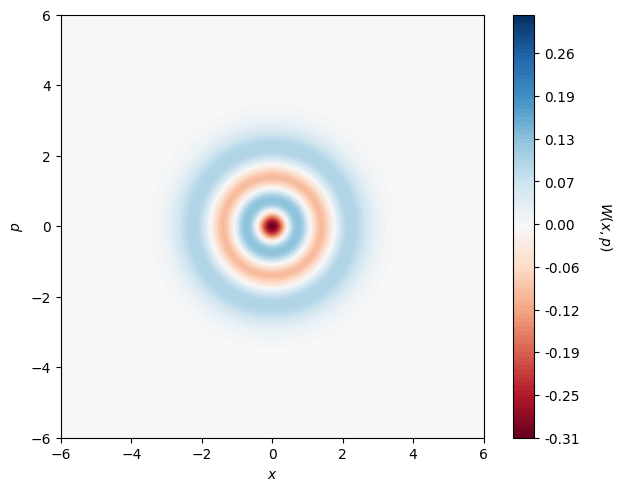

In [26]:
circuit.clear() #reset

#Initialize Fock state and displace by alpha
alpha = 0
circuit.cv_initialize(3, qmr[0])
circuit.cv_d(alpha, qmr[0])

#Simulate and plot
state, _, _ = c2qa.util.simulate(circuit)
c2qa.wigner.plot_wigner(circuit, state)
